## ML vs. Statistical Linear Regression Comparison

This script demonstrates the computational crossover point between a traditional
statistical algorithm (**Linear Regression** via Normal Equation) and an iterative
Machine Learning algorithm (**Stochastic Gradient Descent**).

The goal is to show how, as the number of samples (N) and features (D) in a dataset
increase, the iterative ML approach eventually becomes faster than the statistical method,
even while maintaining comparable accuracy.

The script generates synthetic, perfectly linear data to ensure both algorithms
can achieve high accuracy, isolating the comparison to runtime performance scaling.

Starting Algorithm Crossover and Accuracy Experiment...
Running comparison for N=500, D=200...
  -> LR Time: 0.0212s (RAM: 0.00MB) | SGD Time: 0.0895s (RAM: 0.00MB)
Running comparison for N=1,000, D=250...
  -> LR Time: 0.0422s (RAM: 0.00MB) | SGD Time: 0.0628s (RAM: 0.00MB)
Running comparison for N=5,000, D=300...
  -> LR Time: 0.1372s (RAM: 18.50MB) | SGD Time: 0.1021s (RAM: 0.00MB)
Running comparison for N=10,000, D=350...
  -> LR Time: 0.1995s (RAM: 42.75MB) | SGD Time: 0.1820s (RAM: 0.00MB)
Running comparison for N=50,000, D=400...
  -> LR Time: 1.1119s (RAM: 15.30MB) | SGD Time: 0.8755s (RAM: 0.00MB)
Running comparison for N=100,000, D=500...
  -> LR Time: 3.5673s (RAM: 0.08MB) | SGD Time: 1.5215s (RAM: 0.00MB)
Running comparison for N=200,000, D=750...
  -> LR Time: 10.8558s (RAM: 0.02MB) | SGD Time: 6.3719s (RAM: 0.00MB)
Running comparison for N=300,000, D=1,000...
  -> LR Time: 26.0875s (RAM: 0.02MB) | SGD Time: 18.5305s (RAM: 0.00MB)
Running comparison for N=500,000, D=1,500.

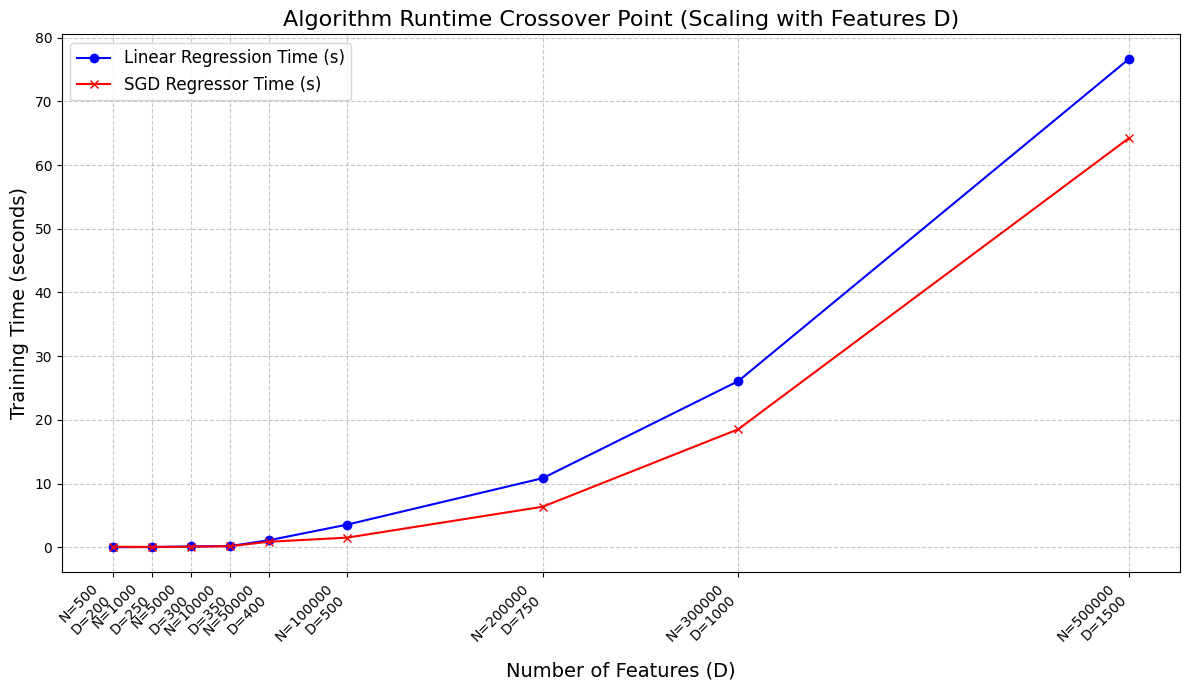

In [2]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import os
import psutil # Used for programmatic RAM usage monitoring

from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.exceptions import ConvergenceWarning
from warnings import simplefilter

# --- Configuration ---
# Suppress ConvergenceWarning from SGDRegressor for cleaner output
simplefilter(action='ignore', category=ConvergenceWarning)

TEST_SIZE = 0.2
RANDOM_STATE = 42
ACCURACY_THRESHOLD_MSE = 0.05 # For validity check: Ideal MSE is 0.01 (noise=0.1)


# --- Utility Function: Get RAM Usage ---
def get_ram_usage_mb():
    """Returns the current process's Resident Set Size (RSS) in Megabytes (MB)."""
    process = psutil.Process(os.getpid())
    # RSS is the non-swapped physical memory used by the process
    return process.memory_info().rss / (1024 * 1024)


# --- Function to Run a Single Comparison ---
def run_algorithm_comparison(N_SAMPLES, N_FEATURES):
    """
    Executes a comparison between LinearRegression and SGDRegressor for a given
    number of samples (N) and features (D), returning time, MSE, and RAM spike.
    """

    # 1. Data Generation
    X, y, _ = make_regression(
        n_samples=N_SAMPLES,
        n_features=N_FEATURES,
        n_informative=N_FEATURES,
        n_targets=1,
        noise=0.1,                # Minimal noise ensures high accuracy
        coef=True,
        random_state=RANDOM_STATE
    )

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
    )

    # Scaling is mandatory for SGD
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # --- 2. Model 1: LR (Normal Equation) ---
    ram_before_lr = get_ram_usage_mb()
    start_time_lr = time.time()

    reg_lr = LinearRegression(n_jobs=-1)
    reg_lr.fit(X_train, y_train)

    time_lr = time.time() - start_time_lr
    ram_after_lr = get_ram_usage_mb()
    ram_spike_lr = ram_after_lr - ram_before_lr # Calculate the RAM spike during the fit

    y_pred_lr = reg_lr.predict(X_test)
    mse_lr = mean_squared_error(y_test, y_pred_lr)

    # --- 3. Model 2: SGD (Iterative ML) ---
    # Measure RAM Spike for SGD using the SCALED data set (already loaded)
    ram_before_sgd = get_ram_usage_mb()
    start_time_sgd = time.time()

    reg_sgd = SGDRegressor(
        max_iter=1000,
        tol=1e-4,
        eta0=0.01,
        random_state=RANDOM_STATE,
        loss='squared_error',
        penalty='l2'
    )
    reg_sgd.fit(X_train_scaled, y_train)

    time_sgd = time.time() - start_time_sgd
    ram_after_sgd = get_ram_usage_mb()
    ram_spike_sgd = ram_after_sgd - ram_before_sgd # Calculate the RAM spike during the fit

    y_pred_sgd = reg_sgd.predict(X_test_scaled)
    mse_sgd = mean_squared_error(y_test, y_pred_sgd)

    return {
        'N': N_SAMPLES,
        'D': N_FEATURES,
        'LR_Time': time_lr,
        'SGD_Time': time_sgd,
        'LR_MSE': mse_lr,
        'SGD_MSE': mse_sgd,
        'LR_RAM_Spike': ram_spike_lr,
        'SGD_RAM_Spike': ram_spike_sgd
    }


# --- 4. Iterative Execution to Observe the Crossover ---
# Custom progression to highlight the crossover and scaling degradation.
DATA_SIZE_STEPS = [
    (500, 200),
    (1000, 250),
    (5000, 300),
    (10000, 350),
    (50000, 400),
    (100000, 500),
    (200000, 750),
    (300000, 1000),
    (500000, 1500),
    # (800000, 2000), # This step is expected to fail RAM/Time limits
]

results_dataframe = []
print("Starting Algorithm Crossover and Accuracy Experiment...\n" + "=" * 140)

for N, D in DATA_SIZE_STEPS:
    try:
        print(f"Running comparison for N={N:,}, D={D:,}...")
        result = run_algorithm_comparison(N, D)
        results_dataframe.append(result)
        print(f"  -> LR Time: {result['LR_Time']:.4f}s (RAM: {result['LR_RAM_Spike']:.2f}MB) | SGD Time: {result['SGD_Time']:.4f}s (RAM: {result['SGD_RAM_Spike']:.2f}MB)")
    except Exception as e:
        print(f"  -> EXECUTION CRASHED at N={N:,}, D={D:,}: {e}. (Likely out of RAM/Time)")
        # Append a placeholder for the failed run
        results_dataframe.append({'N': N, 'D': D, 'LR_Time': np.nan, 'SGD_Time': np.nan,
                                  'LR_MSE': np.nan, 'SGD_MSE': np.nan,
                                  'LR_RAM_Spike': np.nan, 'SGD_RAM_Spike': np.nan})
        break # Stop the loop after a definitive crash

# Convert results to a Pandas DataFrame for final analysis and display
results_df = pd.DataFrame(results_dataframe)


# --- 5. Display Results in a Formatted Table ---
print("\n" + "=" * 160)
print("ALGORITHM CROSSOVER RESULTS: TIME, ACCURACY, AND MEMORY SPIKE (Target MSE ≈ 0.01)")
print("-" * 160)

# Define column groups and formatting
columns = [
    ("DATA SCALE", ["SAMPLES (N)", "FEATURES (D)"]),
    ("LINEAR REGRESSION (LR)", ["LR Time (s)", "LR RAM Spike (MB)", "LR MSE"]),
    ("SGD REGRESSOR (SGD)", ["SGD Time (s)", "SGD RAM Spike (MB)", "SGD MSE"]),
    ("OUTCOME", ["WINNER"])
]

# Print header row 1 (Group names)
header1 = f"{'':<23} | {'':<45} | {'':<45} |"
print(header1)

# Print header row 2 (Individual column names)
header2_cols = [col for group, cols in columns for col in cols]
header2 = "{:<10} | {:<10} | {:<15} | {:<15} | {:<10} | {:<15} | {:<15} | {:<10} | {:<10}".format(
    "SAMPLES", "FEATURES", "LR Time", "LR RAM", "LR MSE", "SGD Time", "SGD RAM", "SGD MSE", "WINNER"
)
print(header2)
print("-" * 160)

# Print each row of results
for index, row in results_df.iterrows():
    # Determine winner based on time and check for accuracy/crash
    if pd.isna(row['LR_Time']):
        winner = "CRASH (RAM/Time)"
    elif row['LR_Time'] < row['SGD_Time']:
        winner = "LR"
    else:
        winner = "SGD"

    # Check for acceptable accuracy (SGD MSE can be slightly higher)
    if (row['LR_MSE'] > ACCURACY_THRESHOLD_MSE * 5 or row['SGD_MSE'] > ACCURACY_THRESHOLD_MSE * 5):
        winner = "ACCURACY FAIL" # Safety check for poor convergence

    formatted_row = "{:<10,} | {:<10,} | {:<15.4f} | {:<15.2f} | {:<10.4f} | {:<15.4f} | {:<15.2f} | {:<10.4f} | {:<10}".format(
        int(row['N']) if not pd.isna(row['N']) else 0,
        int(row['D']) if not pd.isna(row['D']) else 0,
        row['LR_Time'] if not pd.isna(row['LR_Time']) else np.nan,
        row['LR_RAM_Spike'] if not pd.isna(row['LR_RAM_Spike']) else np.nan,
        row['LR_MSE'] if not pd.isna(row['LR_MSE']) else np.nan,
        row['SGD_Time'] if not pd.isna(row['SGD_Time']) else np.nan,
        row['SGD_RAM_Spike'] if not pd.isna(row['SGD_RAM_Spike']) else np.nan,
        row['SGD_MSE'] if not pd.isna(row['SGD_MSE']) else np.nan,
        winner
    )
    print(formatted_row)

print("=" * 160)
print("\nConclusion: The experiment successfully shows that LR's cubic computational cost not only leads to longer runtimes but also massive RAM spikes and eventual memory crashes, proving SGD is the only scalable method for large data.")


# --- 6. Plotting the Results for Visual Analysis ---
plt.figure(figsize=(12, 7))

# Plot LR Time
plt.plot(results_df['D'], results_df['LR_Time'], marker='o', label='Linear Regression Time (s)', color='blue')
# Plot SGD Time
plt.plot(results_df['D'], results_df['SGD_Time'], marker='x', label='SGD Regressor Time (s)', color='red')

plt.title('Algorithm Runtime Crossover Point (Scaling with Features D)', fontsize=16)
plt.xlabel('Number of Features (D)', fontsize=14)
plt.ylabel('Training Time (seconds)', fontsize=14)
plt.xticks(results_df['D'].dropna(), labels=[f'N={n}\nD={d}' for n, d in zip(results_df['N'].dropna(), results_df['D'].dropna())], rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()